In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [20]:
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

######################## IMPLEMENTING PERSISTENT MINIMUM SCHEME ####

def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

######################## IMPLEMENTING SILENT PERIODS SCHEME ####

def getForSilentPeriods(inp, rms, threshold=15):
    silentPreds = []
    for i in range(0, len(inp)):
        if rms[i] < threshold:   # if it was silent during this prediction
            silentPreds.append(inp[i])   # then add this to the list
    if len(silentPreds) > 0:
        return avg(silentPreds)
    else:
        return 0

In [4]:
from joblib import dump,load
#dump(reg, 'Model4flowSense4.joblib')
reg = load('Model5flowSense6.joblib')

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.24.2 when using version 1.0.1. This might 

Mean Squared Error:  2.2000233454595777


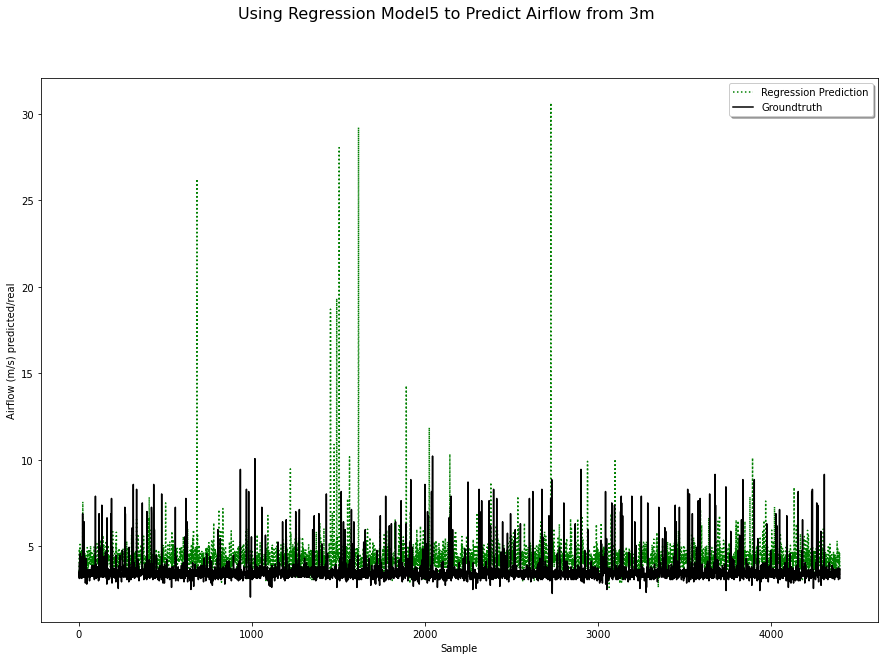

Mean Squared Error:  2.690109872995158
Mean Squared Error:  3.8255880581752217
Mean Squared Error:  1.671304189221515
Mean Squared Error:  1.4893702305365546
Mean Squared Error:  2.3288894844977013
[2.690109872995158, 3.8255880581752217, 1.671304189221515, 1.4893702305365546, 2.3288894844977013]


In [5]:
MSE_scores30 = []

#Looking at predictions from 3m
data_dir = Path("./3m") 
df1 = pd.read_csv(data_dir / "fft_3_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_3_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_3_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df = df1
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model5 to Predict Airflow from 3m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4000), range(4000,8000), range(8000,12000), range(12000, 16000), range(16000, 20000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores30.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores30)

Mean Squared Error:  2.9498380326435107


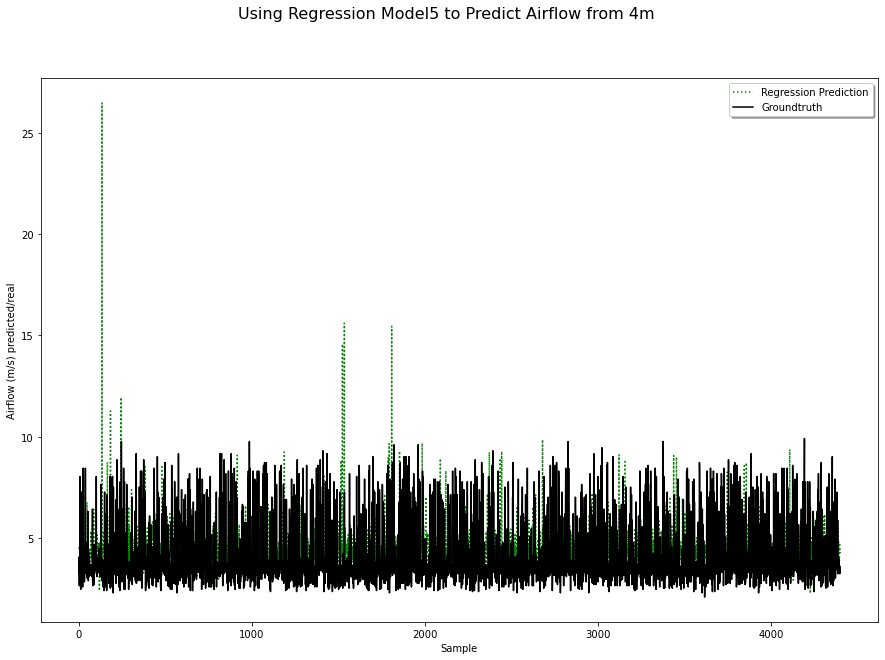

Mean Squared Error:  2.580092640379787
Mean Squared Error:  2.7363981864691
Mean Squared Error:  3.354256183701403
Mean Squared Error:  2.533027507908195
Mean Squared Error:  3.1361842553364148
[2.580092640379787, 2.7363981864691, 3.354256183701403, 2.533027507908195, 3.1361842553364148]


In [6]:
MSE_scores40 = []

#Looking at predictions from 4m
data_dir = Path("./4m") 
df1 = pd.read_csv(data_dir / "fft_4_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_4_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_4_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df = df3
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model5 to Predict Airflow from 4m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(2500), range(2500,5000), range(5000,7500), range(7500, 10000), range(10000, 12500)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores40.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores40)

In [7]:
from pathlib import Path

scores_P1_5u = []
scores_P1_5o = []
scores_P1_2u = []
scores_P1_2o = []
scores_P1_2h = []

#Looking at predictions from PHONE1 realworld
data_dir = Path("./RealWorld") 
df1 = pd.read_csv(data_dir / "fft_50_U_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_50_O_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_225_U_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "fft_225_O_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4[df4['frequency'] != "silence"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "fft_2_O_P1_INHAND.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5[df5['frequency'] != "silence"]
df5 = df5.dropna()

df = convert(df1)
for indices in  [range(3000,4000), range(4000,5000), range(5000,6000), range(6000,7000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_5u.append(mean_squared_error(reg.predict(X), y))
        
df = convert(df2)
for indices in [range(3000,4000), range(4000,5000), range(5000,6000), range(6000,7000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_5o.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df3)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2u.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df4)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2o.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df5)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2h.append(mean_squared_error(reg.predict(X), y))

In [8]:
print("Phone1 0.5m, unocc")
print(sum(scores_P1_5u) / len(scores_P1_5u))
print("")
print("Phone1 0.5m, occ")
print(sum(scores_P1_5o) / len(scores_P1_5o))
print("")
print("Phone1 2.25m, unocc")
print(sum(scores_P1_2u) / len(scores_P1_2u))
print("")
print("Phone1 2.25m, occ")
print(sum(scores_P1_2o) / len(scores_P1_2o))
print("")
print("Phone1 2.25m, hand")
print(sum(scores_P1_2h) / len(scores_P1_2h))

Phone1 0.5m, unocc
3.0209845937273934

Phone1 0.5m, occ
3.8409857216484875

Phone1 2.25m, unocc
3.550428700205287

Phone1 2.25m, occ
16.29156714613502

Phone1 2.25m, hand
10.599014916132269


Mean Squared Error:  2.9360829588037407


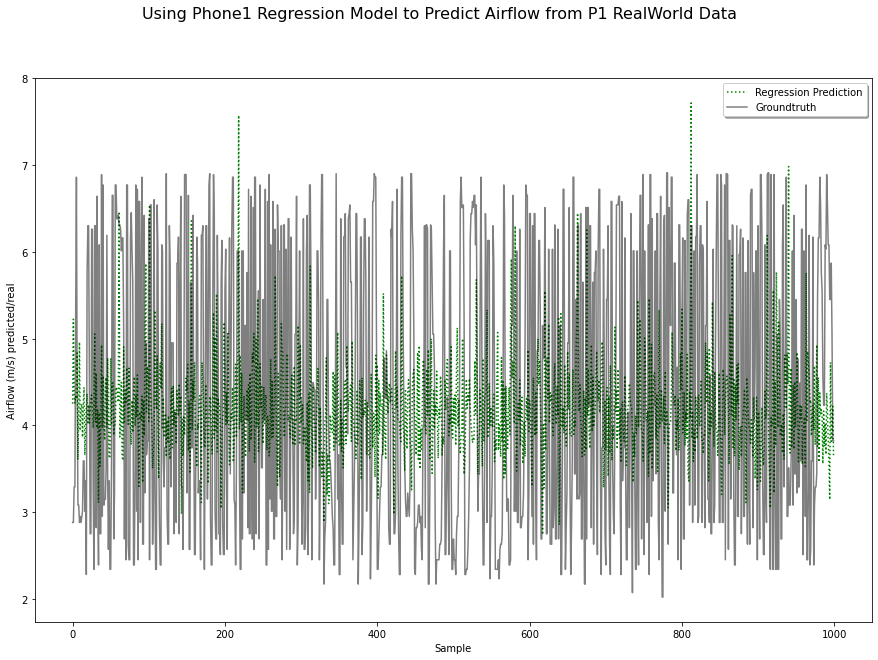

In [9]:
#Looking at predictions from PHONE1 realworld
data_dir = Path("./RealWorld") 
df1 = pd.read_csv(data_dir / "fft_50_U_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_50_O_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_225_U_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "fft_225_O_P1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4[df4['frequency'] != "silence"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "fft_2_O_P1_INHAND.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5[df5['frequency'] != "silence"]
df5 = df5.dropna()

df = df1
data_mid = convert(df)
data_mid.shape

#indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)
#indices = range(9000, 13000)
indices = range(2000,3000)
    
X = data_mid[indices,:-1]
X = X[:, :6]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from P1 RealWorld Data', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.5)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  3.0405071171966855


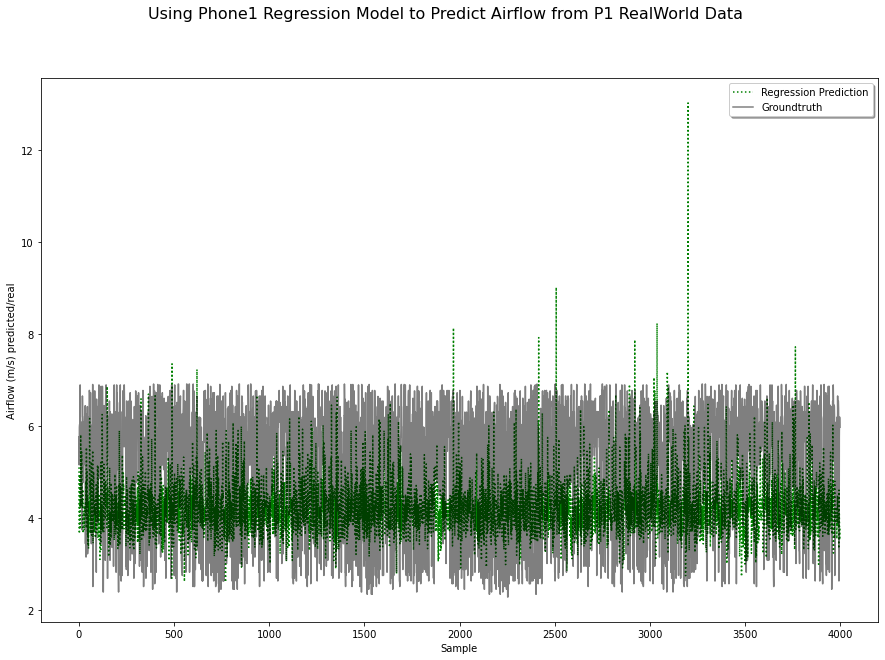

In [10]:
#Looking at predictions from PHONE3 realworld
data_dir = Path("./RealWorld") 

df3 = pd.read_csv(data_dir / "fft_225_U_P3.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df = df1
data_mid = convert(df)
data_mid.shape

#indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)
indices = range(9000, 13000)
    
X = data_mid[indices,:-1]
X = X[:, :6]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from P1 RealWorld Data', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.5)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

[26.         71.5166     37.4208     46.0346     20.0998     29.1429
 14.9562     61.6837     54.          3.         12.25075685]


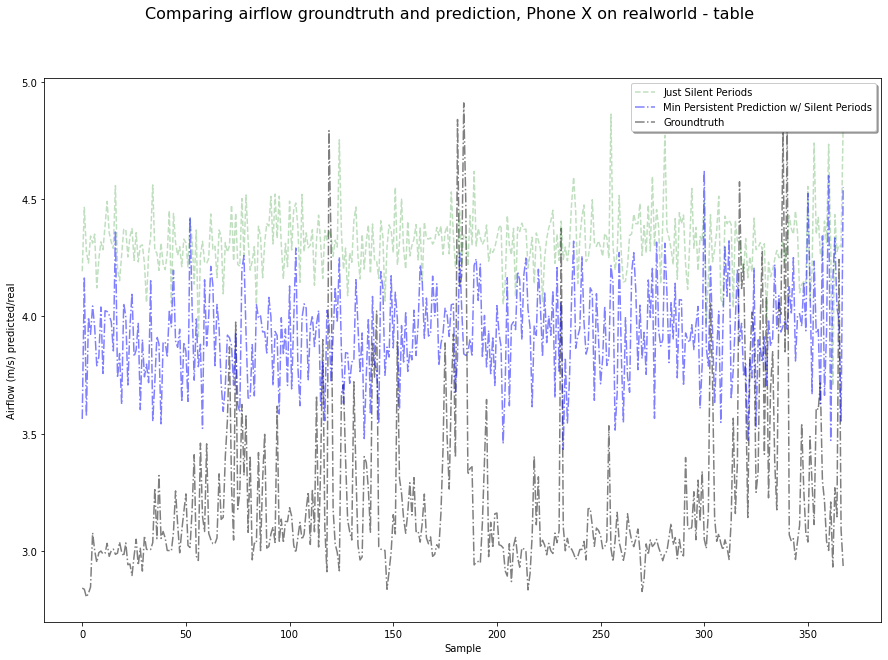

0.685778073382706


In [29]:
#Looking at predictions from realworld TABLE data
data_dir = Path("./RealWorld")
df1 = pd.read_csv(data_dir / "fft_225_U_P2.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

def avg(lst):
    return sum(lst) / len(lst)

print(df[0])
indices = range(15000)

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []
threshold = 15

for i in range(1, df.shape[0]):
    if(df[i][-1] > threshold): # if rms value is larger than threshold, totally skip this data point
        tempGround.append(df[i][-2])
        continue
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred, num=3)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction, Phone X on realworld - table', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.25)
l2, = ax1.plot(minimumPersistent, 'b-.', alpha = 0.5)
#l3, = ax1.plot(totalMinimum, 'p-', alpha = 0.2)
ax1.legend((l0, l2, l1), ('Just Silent Periods', 'Min Persistent Prediction w/ Silent Periods', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

print(mean_squared_error(minimumPersistent, groundtruths))

In [11]:
#ERROR BAR GRAPH CODE
# Calculate the average
five_mean = np.mean(MSE_scores05)
one_mean = np.mean(MSE_scores10)
onefive_mean = np.mean(MSE_scores15)
two_mean = np.mean(MSE_scores22)

# Calculate the standard deviation
five_std = np.std(MSE_scores05)
one_std = np.std(MSE_scores10)
onefive_std = np.std(MSE_scores15)
two_std = np.std(MSE_scores22)

# Define labels, positions, bar heights and error bar heights
labels = ['0.5m', '1.0m', '1.5m', '2.25m']
x_pos = np.arange(len(labels))
CTEs = [five_mean, one_mean, onefive_mean, two_mean]
error = [five_std, one_std, onefive_std, two_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean Squared Error at Position 0 for different distances')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Model4_error_bars_MSE_0.png')
plt.show()

NameError: name 'MSE_scores05' is not defined

In [12]:
#Looking at predictions from Vent2
data_dir = Path("./Vent2") 
df2 = pd.read_csv(data_dir / "fft_100_0_Vent2_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()

df = df2
df = convert(df)
df.shape

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :4]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Vent2', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

ValueError: X has 4 features, but GradientBoostingRegressor is expecting 6 features as input.

In [13]:
#Looking at predictions from Vent4
data_dir = Path("./Vent4 (CICS)") 
df1 = pd.read_csv(data_dir / "fft_100_0_Vent4_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = df1
df = convert(df)
df.shape

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :4]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Vent4', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

ValueError: X has 4 features, but GradientBoostingRegressor is expecting 6 features as input.

In [14]:
MSE_vent1 = []
MSE_vent2 = []
MSE_vent4 = []

df = df4 #Vent1, at 1 m away and orientation 0
for indices in [range(2000), range(2000,4000), range(4000,6000), range(6000,8000), range(8000,10000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_vent1.append(mean_squared_error(reg.predict(X), y))

df = convert(df2) #Vent2
for indices in [range(2000), range(2000,4000), range(4000,6000), range(6000,8000), range(8000,10000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_vent2.append(mean_squared_error(reg.predict(X), y))
        
df = convert(df1) #Vent4
for indices in [range(2000), range(2000,4000), range(4000,6000), range(6000,8000), range(8000,10000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_vent4.append(mean_squared_error(reg.predict(X), y))

TypeError: '(slice(None, None, None), slice(None, -1, None))' is an invalid key

/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adam/miniforge3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283

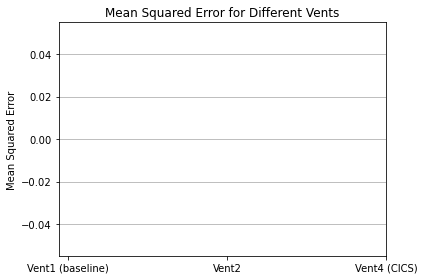

In [15]:
#ERROR BAR GRAPH CODE
# Calculate the average
mean1 = np.mean(MSE_vent1)
mean2 = np.mean(MSE_vent2)
mean4 = np.mean(MSE_vent4)

# Calculate the standard deviation
std1 = np.std(MSE_vent1)
std2 = np.std(MSE_vent2)
std4 = np.std(MSE_vent4)

# Define labels, positions, bar heights and error bar heights
labels = ['Vent1 (baseline)', 'Vent2', 'Vent4 (CICS)']
x_pos = np.arange(len(labels))
CTEs = [mean1,mean2,mean4]
error = [std1,std2,std4]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean Squared Error for Different Vents')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Model4_error_bars_MSE_OTHERVENTS.png')
plt.show()

In [16]:
from pathlib import Path

#Looking at predictions from Noise Study
data_dir = Path("./Noise-Study") 
df1 = pd.read_csv(data_dir / "fft_225_90_Vent1_30.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_225_90_Vent1_60.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_225_90_Vent1_90.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "fft_225_90_Vent1_50Crowd.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "fft_225_90_Vent1_50Vacuum.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()

data_dir = Path("./NoAir-Data")
df6 = pd.read_csv(data_dir / "fftNoAirAmbient.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df6 = df6[df6['frequency'] != "clocktime"]
df6 = df6.dropna()

df = df6
df = convert(df, frame_size=11)
print(df)

indices = range(4000)
    
X = df[:,:-1]
X = X[indices, :4]
X.shape

y = df[indices, -2]
y.shape

rms = df[indices, -1]
rms.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Noise Study', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Noise Study, No Air Ambient Noise, plot RMS values', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(rms, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'RMS Values'), loc='upper right', shadow=True)
plt.show()

MSE_30 = []
MSE_60 = []
MSE_90 = []
MSE_Crowd = []
MSE_Vacuum = []

[[ 18.          17.8039      95.631      ... 170.           0.
   20.71206225]
 [ 14.          16.3321      10.1966     ...  38.           0.
   14.87352682]
 [ 28.          60.7132      52.6777     ...  48.           0.
   15.64560916]
 ...
 [152.         144.0273      79.4264     ...  44.           0.
   29.15085275]
 [190.         207.7523      27.5855     ...  38.           0.
   31.60454821]
 [216.         229.1362      24.0889     ... 148.           0.
   32.17569551]]


ValueError: X has 4 features, but GradientBoostingRegressor is expecting 6 features as input.

In [ ]:
df = convert(df1)
for indices in [range(4000,5000), range(5000,6000), range(6000,7000), range(8000,9000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_30.append(mean_squared_error(reg.predict(X), y))
        
df = convert(df2)
for indices in [range(4000,5000), range(5000,6000), range(6000,7000), range(8000,9000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_60.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df3)
for indices in [range(4000,5000), range(5000,6000), range(6000,7000), range(8000,9000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_90.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df4)
for indices in [range(4000,5000), range(5000,6000), range(6000,7000), range(8000,9000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_Crowd.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df5)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :4]
    y = df[indices, -1]
    MSE_Vacuum.append(mean_squared_error(reg.predict(X), y))

In [17]:
#ERROR BAR GRAPH CODE
# Calculate the average
mean30 = np.mean(MSE_30)
mean60 = np.mean(MSE_60)
meanCrowd = np.mean(MSE_Crowd)
meanVacuum = np.mean(MSE_Vacuum)

# Calculate the standard deviation
std30 = np.std(MSE_30)
std60 = np.std(MSE_60)
stdCrowd = np.std(MSE_Crowd)
stdVacuum = np.std(MSE_Vacuum)

# Define labels, positions, bar heights and error bar heights
labels = ['30%', '60%', 'CrowdNoise', 'VacuumNoise']
x_pos = np.arange(len(labels))
CTEs = [mean30,mean60,meanCrowd,meanVacuum]
error = [std30,std60,stdCrowd,stdVacuum]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean Squared Error for Noise Studies')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Model4_error_bars_MSE_NOISESTUDY.png')
plt.show()

NameError: name 'MSE_30' is not defined